<a href="https://colab.research.google.com/github/Deborah-max46/Darknet-analysis/blob/main/Darknet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Darknet Traffic Analysis with Python
This notebook performs data cleaning, exploratory analysis, model training, evaluation, and innovation techniques (feature importance and hyperparameter tuning) on the Darknet network traffic dataset.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Darknet.csv to Darknet.csv


In [2]:
!pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Load dataset
df = pd.read_csv("Darknet.csv")

# Quick info
print(df.info())
print(df.head())

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categorical columns
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Outlier handling (optional)
for col in df.select_dtypes(include='number'):
    df[col] = np.where(df[col] > df[col].quantile(0.99), df[col].quantile(0.99), df[col])




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158616 entries, 0 to 158615
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     158616 non-null  object 
 1   Src IP                      158616 non-null  object 
 2   Src Port                    158616 non-null  int64  
 3   Dst IP                      158616 non-null  object 
 4   Dst Port                    158616 non-null  int64  
 5   Protocol                    158616 non-null  int64  
 6   Timestamp                   158616 non-null  object 
 7   Flow Duration               158616 non-null  int64  
 8   Total Fwd Packet            158616 non-null  int64  
 9   Total Bwd packets           158616 non-null  int64  
 10  Total Length of Fwd Packet  158616 non-null  int64  
 11  Total Length of Bwd Packet  158616 non-null  int64  
 12  Fwd Packet Length Max       158616 non-null  int64  
 13  Fwd Packet Len

Descriptive stats:
              Flow ID         Src IP       Src Port         Dst IP  \
count  158616.000000  158616.000000  158616.000000  158616.000000   
mean    35539.053985     309.535185   38348.079342    2617.787039   
std     22025.267160     745.004693   19247.127535    2324.471773   
min         0.000000       0.000000       0.000000       0.000000   
25%     17680.750000      13.000000   32916.000000     460.000000   
50%     30950.500000      13.000000   43533.000000    2355.000000   
75%     54650.250000     126.000000   53260.000000    4163.000000   
max     78095.850000    3604.850000   64093.700000    7358.000000   

            Dst Port       Protocol      Timestamp  Flow Duration  \
count  158616.000000  158616.000000  158616.000000   1.586160e+05   
mean    17428.562352      10.220671   18015.515648   2.064549e+07   
std     22080.293482       5.398461    8544.158754   3.799665e+07   
min         0.000000       0.000000       0.000000   0.000000e+00   
25%        80

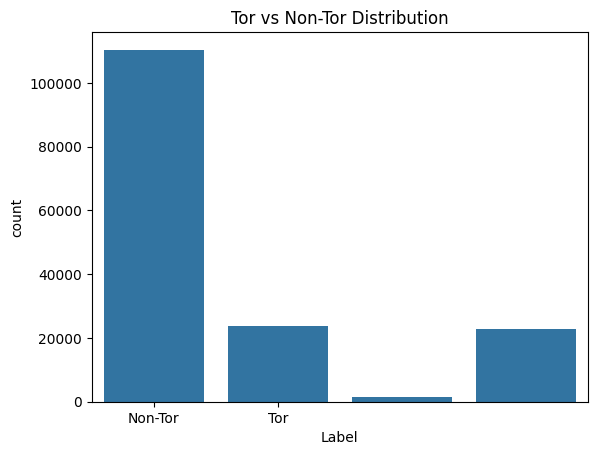

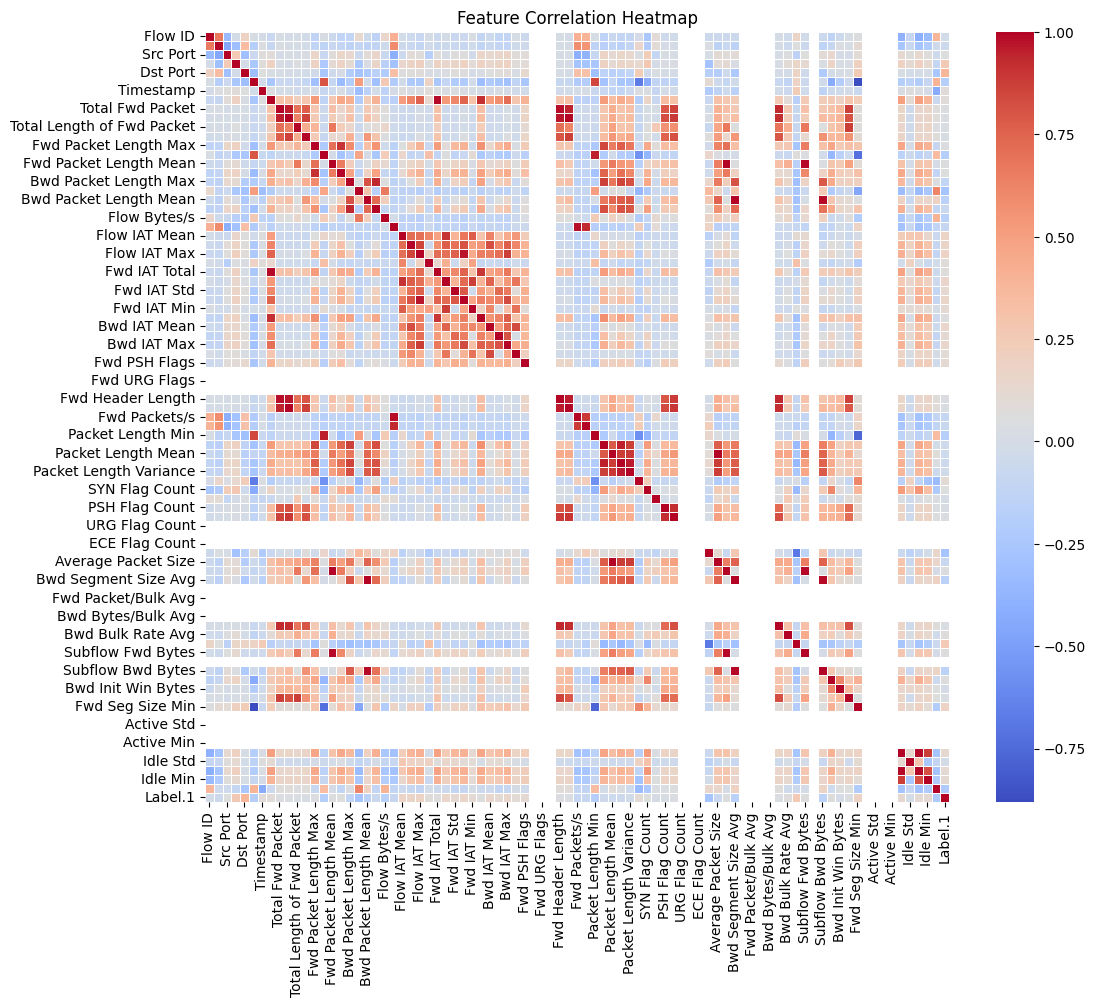

In [2]:
def exploratory_analysis(df):
    print("Descriptive stats:\n", df.describe())
    sns.countplot(x='Label', data=df)
    plt.title("Tor vs Non-Tor Distribution")
    plt.xticks(ticks=[0,1], labels=["Non-Tor", "Tor"])
    plt.show()
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

exploratory_analysis(df)

In [3]:
def scale_features(df):
    X = df.drop("Label", axis=1)
    y = df["Label"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

X, y = scale_features(df)

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21983
         1.0       1.00      1.00      1.00      4839
         2.0       1.00      0.98      0.99       282
         3.0       1.00      1.00      1.00      4620

    accuracy                           1.00     31724
   macro avg       1.00      0.99      1.00     31724
weighted avg       1.00      1.00      1.00     31724



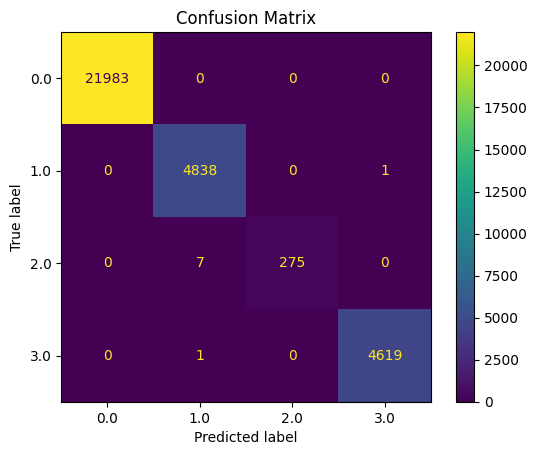

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()
    return model, X_train, X_test, y_train, y_test

model, X_train, X_test, y_train, y_test = train_model(X, y)

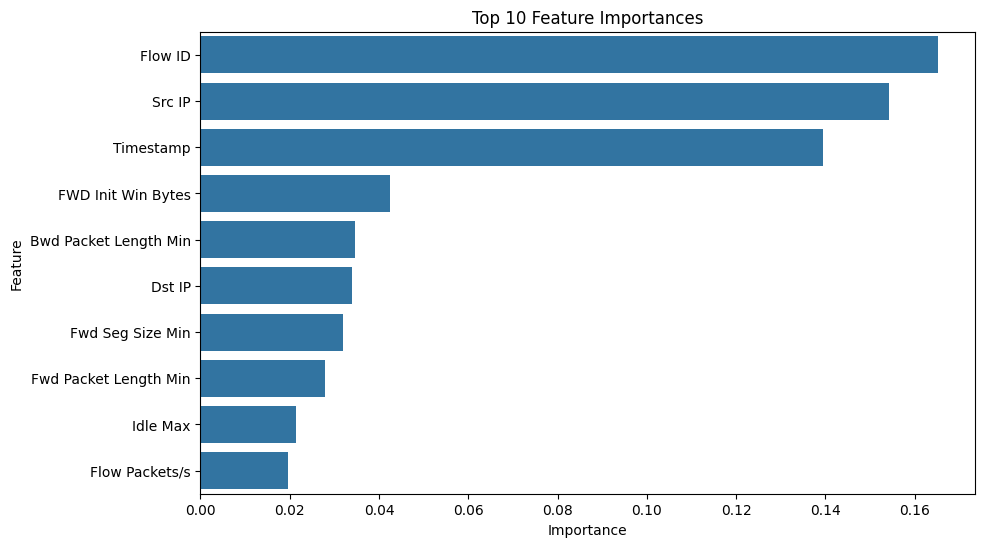

In [6]:
def feature_importance(model, df):
    importances = model.feature_importances_
    features = df.drop("Label", axis=1).columns
    importance_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
    plt.title("Top 10 Feature Importances")
    plt.show()

feature_importance(model, df)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=3,
        verbose=1,
        n_jobs=1  # Set n_jobs to 1 to enable verbose output
    )
    grid.fit(X_train, y_train)
    print("Best Parameters:", grid.best_params_)
    return grid.best_estimator_

# Uncomment below to run (slow):
# best_model = tune_hyperparameters(X_train, y_train)
